# Stock Prediction Model

***
### 1) Install & Import dependencies

In [ ]:
%pip install yfinance pandas statsmodels numpy matplotlib scikit-learn tensorflow 

In [1]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

******
### 2) Handle Data

In [2]:
# Download data
gs = yf.download("GS", start="2011-01-01", end="2021-01-01")

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Preprocess data
dataset_ex_df = gs.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

***
### 3) Define & Display ARIMA Model

In [4]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

In [5]:
# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [6]:
# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

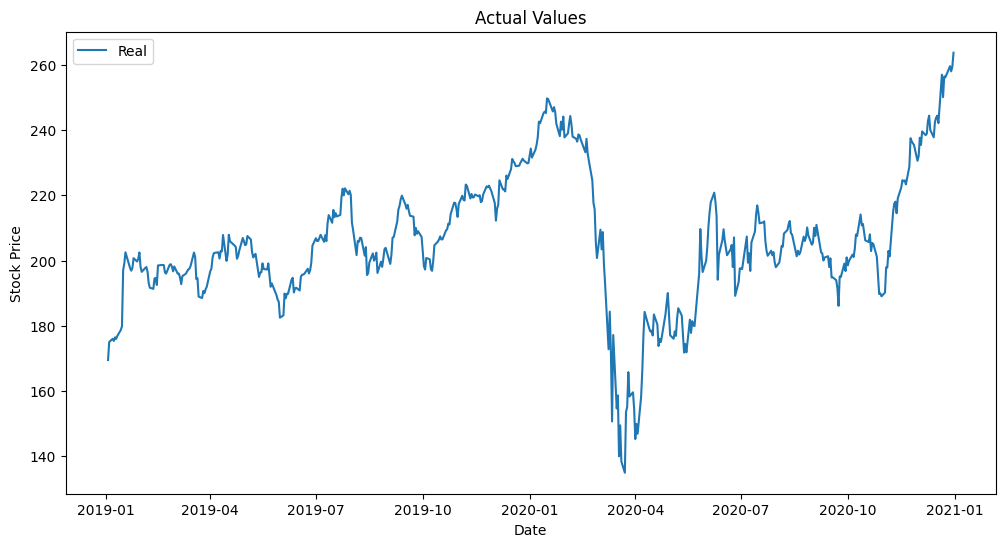

In [7]:
# Plot Actual Stock Values
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.title('Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

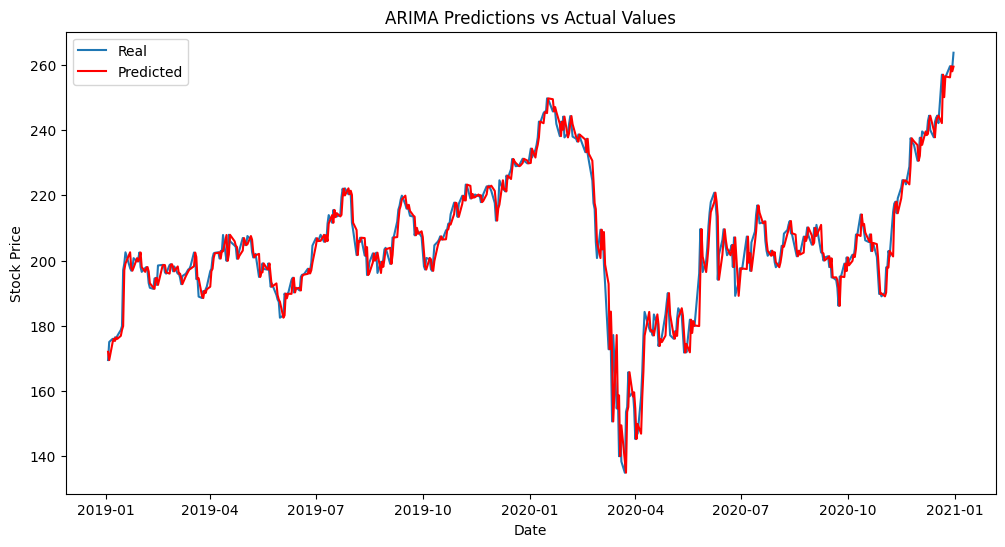

In [8]:
# Plot Predicted Stock Values for Accuracy Comparison
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

***
### 4) Define & Display Fourier Transformation

In [9]:
# Calculate the Fourier Transformations
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

c:\Users\tshadat\OneDrive - Brookfield\desktop\prediction_projects\venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tshadat\OneDrive - Brookfield\desktop\prediction_projects\venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


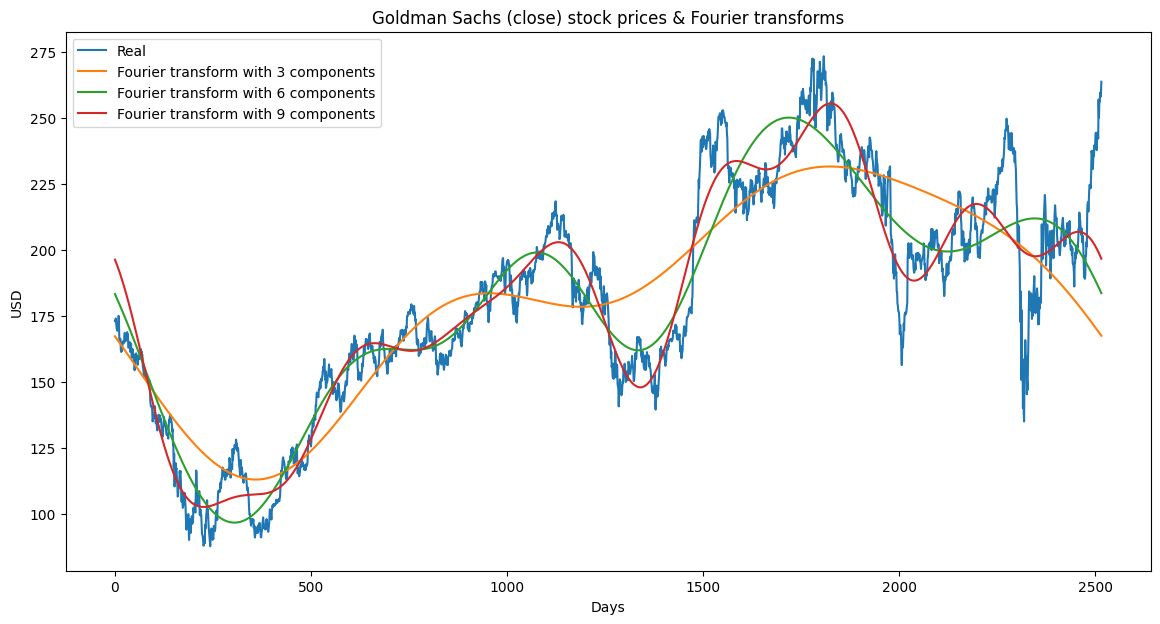

In [10]:
# Plot the Fourier Transformations
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

***
### 5) Calculate & Assess Technical Indicators

In [11]:
# Calculate EMA
def ema(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

In [12]:
# Calculate RSI
def rsi(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [13]:
# Calculate MACD
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line

In [14]:
# Calculate OBV
def obv(close, volume):
    obv = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv

***
### 6) Build Training & Test Data Using Technical Indicators

In [15]:
# Add technical indicators to dataset DF
dataset_ex_df['ema_20'] = ema(gs["Close"], 20)
dataset_ex_df['ema_50'] = ema(gs["Close"], 50)
dataset_ex_df['ema_100'] = ema(gs["Close"], 100)

dataset_ex_df['rsi'] = rsi(gs["Close"])
dataset_ex_df['macd'] = macd(gs["Close"])
dataset_ex_df['obv'] = obv(gs["Close"], gs["Volume"])

In [16]:
# Create arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset_ex_df.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset_ex_df[['ema_20', 'ema_50', 'ema_100', 'rsi', 'macd', 'obv', 'Close']]

In [17]:
# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

# Separate in Train and Test Dfs
train_size = int(len(merged_df) * 0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [18]:
# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

In [19]:
# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values

***
### 7) Training a Deep Learning Model for Prediction

In [20]:
# Define model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

c:\Users\tshadat\OneDrive - Brookfield\desktop\prediction_projects\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=False)

Epoch 1/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.4817 - val_loss: 190.1859
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.3271 - val_loss: 190.1936
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.1719 - val_loss: 190.1934
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.0164 - val_loss: 190.1845
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.8611 - val_loss: 190.1667
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.7063 - val_loss: 190.1391
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.5525 - val_loss: 190.1015
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.4000 - val_loss: 190.0534
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.2490 - val_loss: 189.9946
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.0998 - val_loss: 189.9245
Epoch 11/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9527 - val_loss: 189.8431
Epoch 12/1000
63/63

In [25]:
y_pred = model.predict(X_test)

# Calculate test metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 20.66482217483057
Mean Absolute Error (MAE): 1.332552272164655
R2 Score: 0.9499300922707209
Explained Variance Score: 0.9518533060269937
Mean Absolute Percentage Error (MAPE): 10.715683993894167
Mean Percentage Error (MPE): -0.5896673034977921


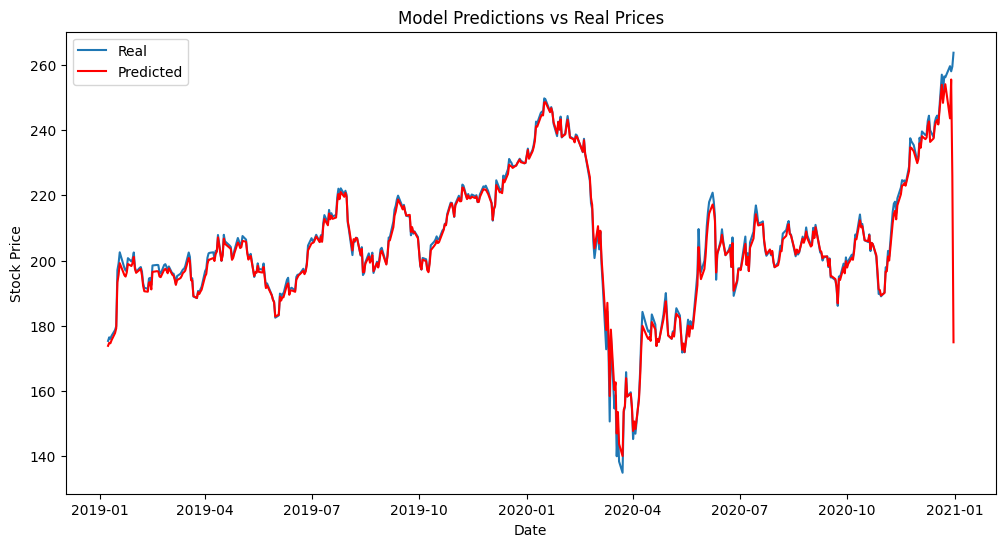

In [26]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

***
### 8) Conclusion
- ##### Now you can predict stocks you're interested in for better informed decisions in your investing!
***